### Временные ряды. Элементраные алгоритмы.
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [195]:
auto = pd.read_csv('/home/data/netology_ml/time_series/data/hw 1 (intro)/monthly-us-auto-registration-tho.csv', sep=';')

In [196]:
auto.columns = ['Month','Auto_registration']

In [197]:
def statvis(series, lags=None):
    print('DF-test p-value is', adfuller(series)[1])
    
    fig, ax = plt.subplots(3,1,figsize=(15,12))
    ax[0].plot(series)
    ax[0].grid()
    ax[0].set_title('Series')
    
    m,b = np.polyfit(range(0,len(series)), series, 1) 
    ax[0].plot(range(0,len(series)), m*range(0,len(series))+b, '-g') 
    
    smt.graphics.plot_acf(series, ax=ax[1], alpha=0.05, lags=lags)
    smt.graphics.plot_pacf(series, ax=ax[2], alpha=0.05, lags=lags)

In [198]:
nonstat = auto.Auto_registration

In [199]:
stat = auto.Auto_registration
stat = boxcox(stat, 0.5)
stat = np.diff(stat, 1)
#stat = np.diff(stat, 12)

DF-test p-value is 0.6627329715655728


/home/data/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


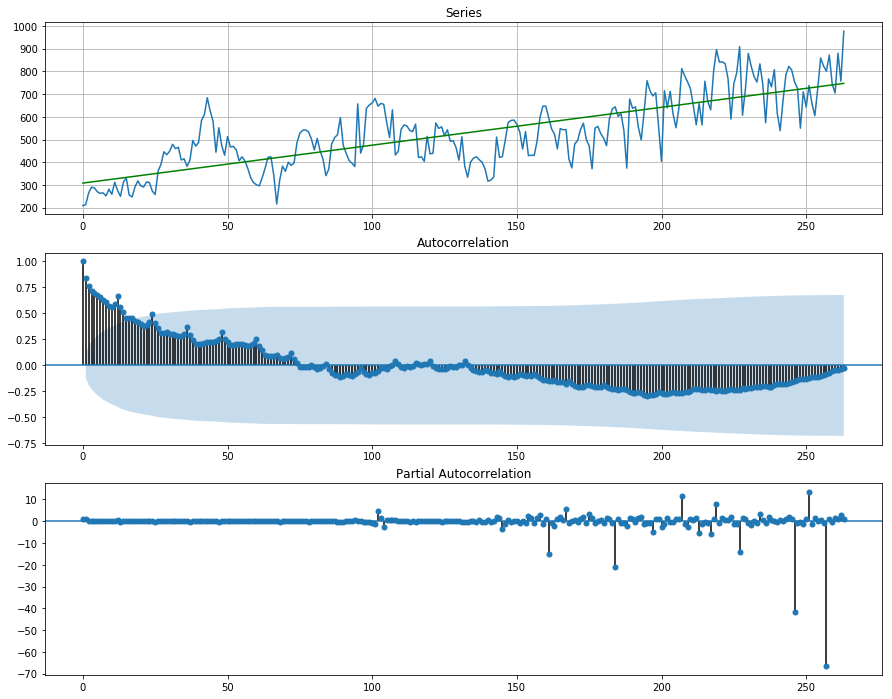

In [200]:
statvis(nonstat)

DF-test p-value is 0.00047188993791459524


/home/data/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


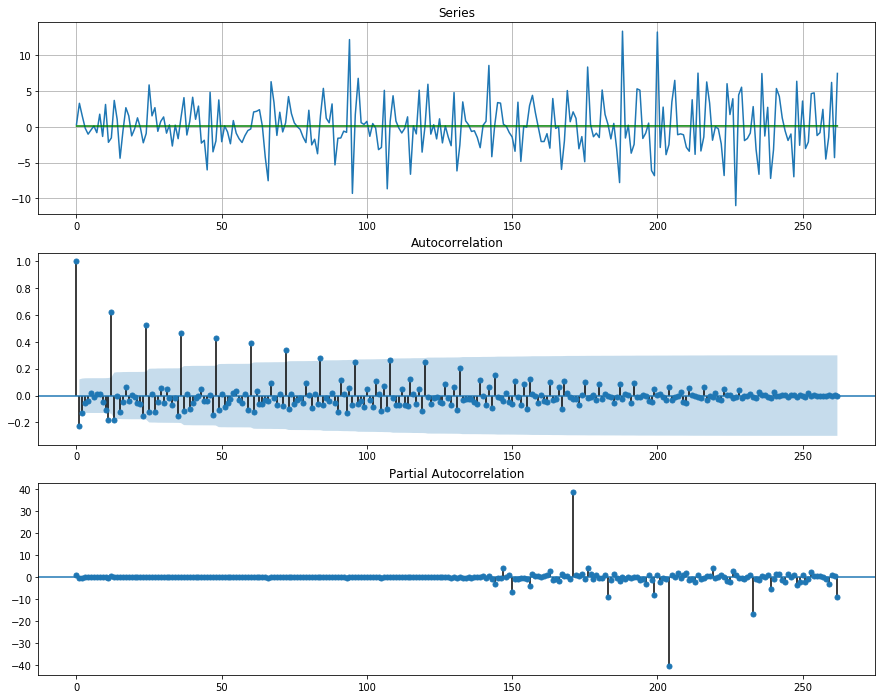

In [201]:
statvis(stat)

Пишем функции основных алгоритмов

In [202]:
def MA_predict(series, predict=5, window=7):
    series = pd.Series(series)    
    new_series = series.copy()
    for _ in range(predict):
        new_series = new_series.append(pd.Series(new_series[-window:].mean()), ignore_index=True)
    return new_series

In [203]:
def WMA_predict(series, predict=5, window=7, w_type='fib', weights=[]):
    series = pd.Series(series)    
    new_series = series.copy()
    
    fib = lambda n: fib(n - 1) + fib(n - 2) if n > 2 else 1
    
    if w_type == 'fib':
        weights=[]
        for i in range(window):
            weights.append(fib(i+1))
    if w_type == '2pow':
        weights=[]
        weights.append(2)
        for i in range(2, window+1):
            weights.append(2**i)     
    if w_type == 'custom' and len(weights) != window:
        return 'Wrong weights array lenght'
        
    weights = weights / np.sum(weights)
    
    for _ in range(predict):
        new_value = new_series[-window:] * weights
        new_value = pd.Series(new_value.sum())
        new_series = new_series.append(new_value, ignore_index=True)
    return new_series

In [204]:
def EMA_predict(series, predict=5, alpha=0.7):
    series = pd.Series(series)
    new_series = series.copy()
    for _ in range(predict):
        predicted = [new_series[0]]
        for n in range(1, len(new_series)):
            predicted.append(alpha * new_series[n] + (1 - alpha) * predicted[n-1])
        new_series = new_series.append(pd.Series(predicted[-1]), ignore_index=True)
    return new_series

In [205]:
def DEMA_predict(series, predict=5, alpha=0.7, beta=0.1):
    series = pd.Series(series)
    new_series = series.copy()
    result = [new_series[0]]
    for _ in range(predict):
        level, trend = [0], [0]
        for i in range(1, len(new_series)):
            level.append(alpha * new_series[i] + (1-alpha) * (result[i-1] + trend[i-1]))
            trend.append(beta * (level[i] - level[i-1]) + (1 - beta) * trend[i-1])
            result.append(level[i] + trend[i])
        new_series = new_series.append(pd.Series(result[-1]), ignore_index=True)
    return new_series

In [206]:
# Подбрил функцию с занятия, слегка её модернизировав. Самому мне такое неписать пока не по силам...
def initial_trend(series, season_len):
    i=0
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def TEMA_predict(series, predict=5, alpha=0.7, beta=0.1, gamma=0.1, slen=12):
    series = pd.Series(series)
    new_series = series.copy()
    
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+predict):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    new_series = new_series.append(pd.Series(result[-predict:]), ignore_index=True)
    return new_series

In [207]:
def reverse_stat(series, value, box_cox=0.5):
    un_diff = []
    un_diff = np.append(un_diff, boxcox(value, box_cox))
    for i in range(len(series)):
        un_diff = np.append(un_diff, un_diff[i] + series[i])
    un_box = (un_diff*box_cox+1)**(1/box_cox)
    return un_box

Предсказываем значения

In [208]:
MA_nonstat = MA_predict(nonstat[:-12], predict=12, window=36)
WMA_nonstat = WMA_predict(nonstat[:-12], predict=12, w_type='fib')
EMA_nonstat = EMA_predict(nonstat[:-12], predict=12, alpha=0.7)
DEMA_nonstat = DEMA_predict(nonstat[:-12], predict=12, alpha=0.7, beta=0.1)
TEMA_nonstat = TEMA_predict(nonstat[:-12], predict=12, alpha=0.7, beta=0.1, gamma=0.2, slen=12)

MA_stat = MA_predict(stat[:-12], predict=12, window=12)
WMA_stat = WMA_predict(stat[:-12], predict=12, w_type='fib')
EMA_stat = EMA_predict(stat[:-12], predict=12, alpha=0.7)
DEMA_stat = DEMA_predict(stat[:-12], predict=12, alpha=0.7, beta=0.1)
TEMA_stat = TEMA_predict(stat[:-12], predict=12, alpha=0.7, beta=0.1, gamma=0.2, slen=12)

MA_stat_reverse = reverse_stat(MA_stat, nonstat[0], box_cox=0.5)
WMA_stat_reverse = reverse_stat(WMA_stat, nonstat[0], box_cox=0.5)
EMA_stat_reverse = reverse_stat(EMA_stat, nonstat[0], box_cox=0.5)
DEMA_stat_reverse = reverse_stat(DEMA_stat, nonstat[0], box_cox=0.5)
TEMA_stat_reverse = reverse_stat(TEMA_stat, nonstat[0], box_cox=0.5)

Считаем ошибки сначала, для прогнозов на нестационарном ряде

In [209]:
from sklearn.metrics import mean_squared_error

In [210]:
# MA nonstat
mean_squared_error(MA_nonstat, nonstat)

569.5102789435067

In [211]:
# WMA nonstat
mean_squared_error(WMA_nonstat, nonstat)

833.7145716361237

In [212]:
# EMA nonstat
mean_squared_error(EMA_nonstat, nonstat)

691.2403861303985

In [213]:
# DEMA nonstat
mean_squared_error(DEMA_nonstat, nonstat)

10934.448909213248

In [214]:
# TEMA nonstat
mean_squared_error(TEMA_nonstat, nonstat)

750.3882831021874

Теперь считаем предсказания по стационарному ряду

In [215]:
# MA stat
mean_squared_error(MA_stat_reverse, nonstat)

365.75022858321785

In [216]:
# WMA stat
mean_squared_error(WMA_stat_reverse, nonstat)

1540.6982082138504

In [217]:
# EMA nonstat
mean_squared_error(EMA_stat_reverse, nonstat)

10317.801813280228

In [218]:
# DEMA stat
mean_squared_error(DEMA_stat_reverse, nonstat)

7478.312450358586

In [219]:
# DEMA stat
mean_squared_error(TEMA_stat_reverse, nonstat)

1631.4672954271198

### Выводы

Проверка качества предсказания осуществлялась по метрике RMSE на отложенных 12 периодах

Для нестационарного ряда лучшие результаты были получены на EMA и TEMA (a=0.7, b=0.1, g=0.2, slen=12)

Для стационарного - простое скользящее среднее (с окном 12) дало наименьшую ошибку.

Лучший результат MA(window = 12) на стационарном ряде с его последующим обратным преобразованием.

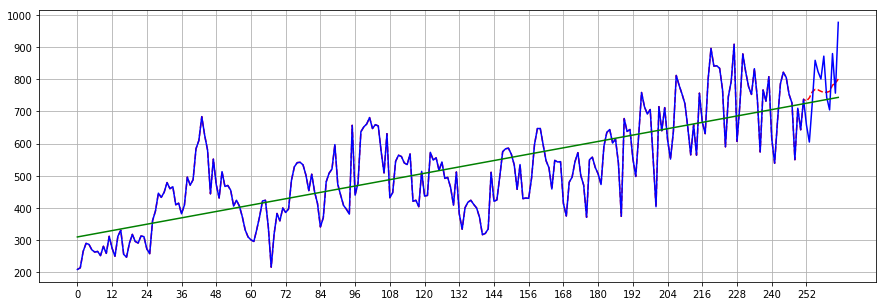

In [222]:
plt.figure(figsize=(15,5))
plt.plot(MA_stat_reverse, 'r--')
plt.plot(nonstat, 'b')
plt.xticks(range(0,len(MA_stat_reverse),12))
plt.grid()

m,b = np.polyfit(range(0,len(MA_stat_reverse)), MA_stat_reverse, 1) 
plt.plot(range(0,len(MA_stat_reverse)), m*range(0,len(MA_stat_reverse))+b, '-g')